# Carregamento dos dados

In [1]:
import pandas as pd

# Carregando os dados do arquivo CSV pré-processado em um DataFrame do pandas
comentarios = pd.read_csv('../Data/content_pre_processado.csv')

# Exibindo as primeiras 5 linhas do DataFrame para verificação
comentarios.head(5)

,reviewId,app_name,content,sentiment_polarity,sentiment
0,01e23c15-44bf-46b7-b280-40e880d9d49b,Shopee,sopre razoável apesar fácil utilizar apresenta...,positive,sadness
1,df40ba7c-075d-48dc-b798-21466dfb41d6,Shopee,otimizar fácil visualizar produto pedido rastr...,positive,sadness
2,59490b23-b17b-4bba-855b-b5053dadc0db,Shopee,prático fácil entender vendedor mandar produto...,positive,sadness
3,48fd8168-1e42-4475-9a99-935c2fd48769,Shopee,aplicativo chatear fato pesquisar produto colo...,positive,sadness
4,f4e1468b-6d97-4f1a-927d-1afee2bfbe75,Shopee,ter dificuldade pagamento cartão crédito compr...,negative,disgust


# BERTimbau

In [2]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import pandas as pd

# Carregar o tokenizer e o modelo BERTimbau
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = BertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased')

# Verificar se há GPU disponível e mover o modelo para a GPU se disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Função para obter previsões do modelo
def predict_sentiment(texts):
    # Tokenizar os textos de entrada
    encodings = tokenizer(texts, truncation=True, padding=True, return_tensors='pt')
    
    # Mover os tensores para o mesmo dispositivo que o modelo
    encodings = {key: val.to(device) for key, val in encodings.items()}
    
    # Fazer previsões
    with torch.no_grad():
        outputs = model(**encodings)
    
    # Obter a classe predita
    predictions = torch.argmax(outputs.logits, dim=-1)
    
    return predictions

# Aplicar o modelo aos comentários
texts = comentarios['content'].tolist()
predictions = predict_sentiment(texts)

# Adicionar as previsões ao DataFrame
comentarios['predictions'] = predictions.cpu().tolist()

# Exibir o DataFrame com as previsões
print(comentarios.head())

c:\Users\dougl\OneDrive\Desktop\Mineracao_Textos\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


                               reviewId app_name  \
0  01e23c15-44bf-46b7-b280-40e880d9d49b   Shopee   
1  df40ba7c-075d-48dc-b798-21466dfb41d6   Shopee   
2  59490b23-b17b-4bba-855b-b5053dadc0db   Shopee   
3  48fd8168-1e42-4475-9a99-935c2fd48769   Shopee   
4  f4e1468b-6d97-4f1a-927d-1afee2bfbe75   Shopee   

                                             content sentiment_polarity  \
0  sopre razoável apesar fácil utilizar apresenta...           positive   
1  otimizar fácil visualizar produto pedido rastr...           positive   
2  prático fácil entender vendedor mandar produto...           positive   
3  aplicativo chatear fato pesquisar produto colo...           positive   
4  ter dificuldade pagamento cartão crédito compr...           negative   

  sentiment  predictions  
0   sadness            0  
1   sadness            0  
2   sadness            0  
3   sadness            0  
4   disgust            0  


# Salvar arquivo com a coluna de previsões

In [3]:
def salvar_csv(df, nome_arquivo):
    df.to_csv(nome_arquivo, index=False, encoding='utf-8')
    print(f"Arquivo salvo como {nome_arquivo}")

salvar_csv(comentarios, '../Data/bertimbau.csv')

Arquivo salvo como ../Data/bertimbau.csv


# Avaliação dos resultados

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd

# Extrair os rótulos verdadeiros e as previsões
true_labels = comentarios['sentiment_polarity'].apply(lambda x: 1 if x == 'positive' else 0).tolist()
predictions = comentarios['predictions'].tolist()

# Calcular a acurácia
accuracy = accuracy_score(true_labels, predictions)

# Relatório detalhado
report = classification_report(true_labels, predictions, target_names=['negative', 'positive'])
print("\nRelatório de Classificação:\n")
print(report)


Relatório de Classificação:

              precision    recall  f1-score   support

    negative       0.59      0.86      0.70      1822
    positive       0.31      0.10      0.15      1187

    accuracy                           0.56      3009
   macro avg       0.45      0.48      0.43      3009
weighted avg       0.48      0.56      0.48      3009



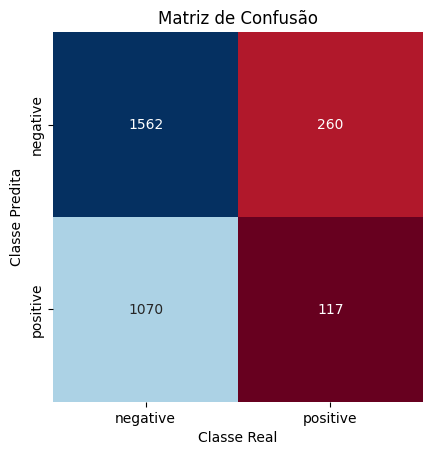

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extrair os rótulos verdadeiros e as previsões
true_labels = comentarios['sentiment_polarity'].apply(lambda x: 1 if x == 'positive' else 0).tolist()
predictions = comentarios['predictions'].tolist()

# Definir os rótulos das classes para a matriz de confusão
sentiment_labels = ['negative', 'positive']

# Calcular a matriz de confusão
cm = confusion_matrix(true_labels, predictions, labels=[0, 1])

# Criar o gráfico da matriz de confusão usando seaborn
sns.heatmap(cm, square=True, annot=True, fmt='d', cmap='RdBu', cbar=False, 
            xticklabels=sentiment_labels,
            yticklabels=sentiment_labels)

plt.xlabel("Classe Real")    # Rótulo do eixo x
plt.ylabel("Classe Predita") # Rótulo do eixo y
plt.title("Matriz de Confusão") # Título do gráfico
plt.show() # Exibir o gráfico
